Importando módulos

In [1]:
import tensorflow as tf
import numpy as np
import time as t
import matplotlib.pyplot as plot 

In [2]:
#Criando função otimizada pelo tensorflow
tempo_otimizado=[]
inicio=t.time()
@tf.function
def funcao_otimizada(x,y):
    for i in range(2000):
        tf.matmul(x,y)
    return tf.matmul(x,y)
tempo_otimizado.append(t.time()-inicio)

#Criando função não otimizada pelo tensorflow
tempo_nao_otimizado=[]
inicio=t.time()
def funcao_nao_otimizada(x,y):
    for i in range(2000):
        tf.matmul(x,y)
    return tf.matmul(x,y)
tempo_nao_otimizado.append(t.time()-inicio)

#Criando função comum com numpy
tempo_comum=[]
inicio=t.time()
def funcao_comum(x,y):
    for i in range(2000):
        tf.matmul(x,y)
    return tf.matmul(x,y)
tempo_comum.append(t.time()-inicio)

#Funções otimizadas pelo tensorflow geralmente demoram mais na primeira execução
#porém, depois dela, elas se tornam mais rápidas, por isso, iremos comparar cinc
#o execuções de cada função.

X=np.random.normal(0,1,[200,50])
Y=np.random.normal(0,1,[50,100])

for i in range(5):
    inicio=t.time()
    funcao_otimizada(X,Y)
    tempo_otimizado.append(t.time()-inicio)
    
    inicio=t.time()
    funcao_nao_otimizada(X,Y)
    tempo_nao_otimizado.append(t.time()-inicio)
    
    inicio=t.time()
    funcao_comum(X,Y)
    tempo_comum.append(t.time()-inicio)
    
print("A função otimizada gastou {0} segundos para ser criada e para execução gastou:\n1ª execução: {1} segundos\n2ª execução: {2} segundos\n3ª execução: {3} segundos\n4ª execução: {4} segundos\n5ª execução: {5} segundos\n".format(*tempo_otimizado))
print("A função não otimizada gastou {0} segundos para ser criada e para execução gastou:\n1ª execução: {1} segundos\n2ª execução: {2} segundos\n3ª execução: {3} segundos\n4ª execução: {4} segundos\n5ª execução: {5} segundos\n".format(*tempo_nao_otimizado))
print("A função comum gastou {0} segundos para ser criada e para execução gastou:\n1ª execução: {1} segundos\n2ª execução: {2} segundos\n3ª execução: {3} segundos\n4ª execução: {4} segundos\n5ª execução: {5} segundos".format(*tempo_comum))


A função otimizada gastou 0.0 segundos para ser criada e para execução gastou:
1ª execução: 7.392054557800293 segundos
2ª execução: 0.001998424530029297 segundos
3ª execução: 0.0009987354278564453 segundos
4ª execução: 0.0009996891021728516 segundos
5ª execução: 0.0009808540344238281 segundos

A função não otimizada gastou 0.0009999275207519531 segundos para ser criada e para execução gastou:
1ª execução: 1.8258533477783203 segundos
2ª execução: 1.4520044326782227 segundos
3ª execução: 1.565033197402954 segundos
4ª execução: 1.6961312294006348 segundos
5ª execução: 1.8218631744384766 segundos

A função comum gastou 0.0 segundos para ser criada e para execução gastou:
1ª execução: 1.5411670207977295 segundos
2ª execução: 1.4760444164276123 segundos
3ª execução: 1.6138818264007568 segundos
4ª execução: 1.5030441284179688 segundos
5ª execução: 1.7579638957977295 segundos


Veja que a função otimizada gasta bastante tempo na primeira execução, porém, após ela, é praticamente instantânea. Vale observar que 0.001 segundos é a mais ou menos a precisão da medida de tempo do Python (para verificar isto, basta rodar esse código algumas vezes e verá que o tempo gasto para criar as funções ocila entre 0.001 e 0.0), por isso podemos considerar que o tempo para a criação de todas as funções foi 0.0 (assim como o tempo para a execução da função otimizada após a primeira execução), desta forma, todas as funções tiveram o mesmo tempo de criação, mesmo com a otimização do TensorFlow, isto me leva a crer que a função é otimizada na primeira execução e não na criação. 

Vamos agora ver um exemplo interressante onde possamos calcular derivadas.

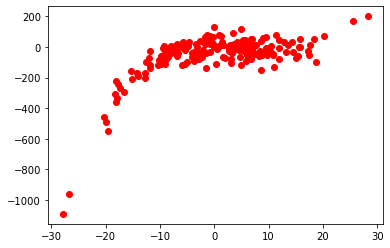

In [3]:
X=tf.random.normal([200,1],0,10)
Y=0.03*X**3-0.48*X**2-0.06*X-1+tf.random.normal([200,1],0,50)

plot.plot(X,Y,'ro')
plot.show()

Vamos fazer uma regressão bayesiana dos pontos acima.

In [4]:
#Tomemos uma priori normal para os pesos e uma verrossimilhança normal.
#Tomemos tau_1 como a precisão da nossa priori e tau_2 como precição da verossimilhança.

tau_1=tf.Variable(1,dtype='float32',trainable=False)
tau_2=tf.Variable(0.01,dtype='float32',trainable=False)

pesos=tf.Variable(tf.random.normal([4,1],0,1),dtype='float32',trainable=True)

matrix_X=tf.concat([X**3,X**2,X,X**0],axis=1)

#Definindo função proporcional ao log da priori multiplicado por -1
@tf.function
def priori():
    return tau_1*tf.math.reduce_mean(pesos**2)

#Definindo função proporcional ao log da verrossimilhança multiplicado por -1
@tf.function
def verrossimilhança():
    predicao=tf.matmul(matrix_X,pesos)
    return tau_2*tf.reduce_mean((predicao-Y)**2)

Agora que temos a posteriori dos pesos, basta amostrar desta distribuição, para isso usaremos uma implementação preguiçosa do método de MCMC chamaado Langevin.

In [5]:
@tf.function
def Langevin(passo):
    #Usando o GradientTape para que o tensorflow acompanhe as variáveis treinaveis no seu uso dentro do escopo do with.
    with tf.GradientTape(persistent=True) as watch_grad:
        erro=priori()+verrossimilhança()
    #Calculando gradiente dos pesos.
    grad=passo*watch_grad.gradient(erro,pesos)
    langevin_noise=tf.random.normal([4,1],0,1)
    #Atualizando pesos.
    pesos.assign(pesos-passo*(grad+langevin_noise))
    return pesos,priori()+verrossimilhança()

Checkpoint.

In [6]:
tau_1.assign(0.1)
tau_2.assign(0.01)
passo_do_langevin=10**(-3)
pesos.assign(tf.random.normal([4,1],0,1))
amostra_de_pesos=pesos
erros=[]

In [7]:
inicio=t.time()
for i in range(10000):
    resultado_langevin=Langevin(passo_do_langevin)
    erros.append(resultado_langevin[1])
    amostra_de_pesos=tf.concat([amostra_de_pesos,resultado_langevin[0]],axis=1)
print(t.time()-inicio)

10.898837089538574


Plotando erros

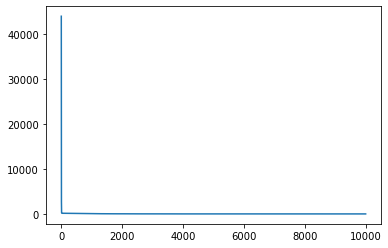

In [8]:
indices=range(1,10001)
plot.plot(indices,erros)
plot.show()

Vamos testar o resultado.

In [9]:
sub_amostra_de_pesos=tf.gather(amostra_de_pesos,np.random.randint(0,9999,1000),axis=1)

In [10]:
X_teste=tf.convert_to_tensor(np.asarray([range(-30,30)]).T,dtype='float32')
matrix_X_teste=tf.concat([X_teste**3,X_teste**2,X_teste,X_teste**0],axis=1)

previsões=tf.matmul(matrix_X_teste,sub_amostra_de_pesos)

media=tf.math.reduce_mean(previsões,axis=1)
desvio_padrao=tf.math.reduce_std(previsões,axis=1)

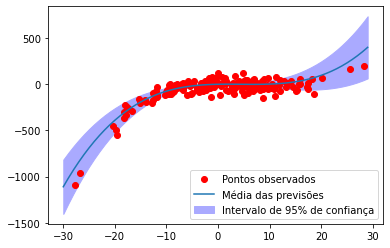

In [11]:
indices=range(1,10001)
plot.plot(X,Y,'ro',label='Pontos observados')
plot.fill_between(X_teste[:,0],media+1.96*desvio_padrao,media-1.96*desvio_padrao,color='#aaaaff',label='Intervalo de 95% de confiança')
plot.plot(X_teste,media,label='Média das previsões')
plot.legend(loc=4)
plot.show()

Certamente você deve estar estranhando que o intervalo de confiança não inclui 95% dos pontos observados, isso se deve a escolha do parâmetro tau_2, pois ele é a precisão do ruído dentro do modelo, assim, claramente o tau_2 escolhido foi pequeno. Obviamente, uma vez que os dados foram gerados artificialmente, eu poderia escolher o tau_2 verdadeiro, porém, preferi deixar um tau_2 incorreto para ilustrar essa questão.

O usuário pode alterar livremente o valor dos parâmetros usados, para isso, use o bloco de código imediatamente após o checkpoint, lembrando que, ao mudar o tau_1 e o tau_2 pode ser que o langevin não convirja, assim, caso os erros estejam convergindo, mas ainda não tenham estalizado, aumente o valor do passo do langevin, caso o erro esteja explodindo, diminua o passo.

Por último, vale observar que os dados estão bastante concentrados em uma região, pois amostrei o X de uma normal, isso faz com que a confiança naquela região seja muito alta, mesmo para tau_2 muito baixos.

Para um breve efeito de comparação, vamos comparar o uso do Langevin com otimização e sem otimização.

In [12]:
def Langevin_sem_otimização(passo):
    #Usando o GradientTape para que o tensorflow acompanhe as variáveis treinaveis no seu uso dentro do escopo do with.
    with tf.GradientTape(persistent=True) as watch_grad:
        erro=priori()+verrossimilhança()
    #Calculando gradiente dos pesos.
    grad=passo*watch_grad.gradient(erro,pesos)
    langevin_noise=tf.random.normal([4,1],0,1)
    #Atualizando pesos.
    pesos.assign(pesos-passo*(grad+langevin_noise))
    return pesos,priori()+verrossimilhança()

In [13]:
tau_1.assign(0.1)
tau_2.assign(0.01)
passo_do_langevin=10**(-3)
pesos.assign(tf.random.normal([4,1],0,1))
amostra_de_pesos=pesos
erros=[]
inicio=t.time()
for i in range(10000):
    resultado_langevin=Langevin(passo_do_langevin)
    erros.append(resultado_langevin[1])
    amostra_de_pesos=tf.concat([amostra_de_pesos,resultado_langevin[0]],axis=1)
print('Langevin otimizado gastou ',t.time()-inicio,' segundos')

Langevin otimizado gastou  9.813573837280273  segundos


In [14]:
tau_1.assign(0.1)
tau_2.assign(0.01)
passo_do_langevin=10**(-3)
pesos.assign(tf.random.normal([4,1],0,1))
amostra_de_pesos=pesos
erros=[]
inicio=t.time()
for i in range(10000):
    resultado_langevin=Langevin_sem_otimização(passo_do_langevin)
    erros.append(resultado_langevin[1])
    amostra_de_pesos=tf.concat([amostra_de_pesos,resultado_langevin[0]],axis=1)
print('Langevin não otimizado gastou ',t.time()-inicio,' segundos')

Langevin não otimizado gastou  59.21962761878967  segundos


Coisas que não devem ser feitas com funções otimizadas

In [15]:
variavel_teste=0
outra_variavel=0
def exemplo_bom():
    global variavel_teste,outra_variavel
    variavel_teste=outra_variavel
    
print('Variavel teste no tempo 1: ',variavel_teste)
outra_variavel=1
exemplo_bom()
print('Variavel teste no tempo 2: ',variavel_teste)
outra_variavel=2
exemplo_bom()
print('Variavel teste no tempo 3: ',variavel_teste)

Variavel teste no tempo 1:  0
Variavel teste no tempo 2:  1
Variavel teste no tempo 3:  2


In [16]:
variavel_teste=0
outra_variavel=0
@tf.function
def exemplo_ruim():
    global variavel_teste,outra_variavel
    variavel_teste=outra_variavel
    
print('Variavel teste no tempo 1: ',variavel_teste)
outra_variavel=1
exemplo_ruim()
print('Variavel teste no tempo 2: ',variavel_teste)
outra_variavel=2
exemplo_ruim()
print('Variavel teste no tempo 3: ',variavel_teste)

Variavel teste no tempo 1:  0
Variavel teste no tempo 2:  1
Variavel teste no tempo 3:  1


Veja que, uma vez que a função otimizada foi compilada, ela não acessará valores externos, pois ela foi compilada fora do python e os valores que não são do tipo tf.Variable são considerados constantes.

In [17]:
variavel_teste=tf.Variable(0)
outra_variavel=tf.Variable(0)
@tf.function
def exemplo_corrigido():
    global variavel_teste,outra_variavel
    variavel_teste.assign(outra_variavel)
    
print('Variavel teste no tempo 1: ',variavel_teste.numpy())
outra_variavel.assign(1)
exemplo_corrigido()
print('Variavel teste no tempo 2: ',variavel_teste.numpy())
outra_variavel.assign(2)
exemplo_corrigido()
print('Variavel teste no tempo 3: ',variavel_teste.numpy())

Variavel teste no tempo 1:  0
Variavel teste no tempo 2:  1
Variavel teste no tempo 3:  2


Ao armazenar o valor da variável em um objeto do tensorflow e atualizando este objeto pelo método adequado, podemos atualizar os valores de maneira adequada.

Apropósito o método numpy serve para que a variável seja retornada como um número (ou vetor) comum, ou seja, este método retorna o valor armazenado na variável.

In [18]:
print(variavel_teste)
print(variavel_teste.numpy())

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2>
2


Uma observação importante é que o problema observado não é apenas uma questão da variável outra_variavel ser constante para a função, as partes do código da função que não se referem a variáveis do tensorflow são executadas apenas na primeira execução e, após compilada, a função irá ignorar estas partes.

In [19]:
variavel_teste=0
@tf.function
def outro_exemplo():
    global variavel_teste
    variavel_teste+=1
    
print('Variavel teste no tempo 1: ',variavel_teste)
outro_exemplo()
print('Variavel teste no tempo 2: ',variavel_teste)
outro_exemplo()
print('Variavel teste no tempo 3: ',variavel_teste)
variavel_teste=10
outro_exemplo()
print('Variavel teste no tempo 4: ',variavel_teste)

Variavel teste no tempo 1:  0
Variavel teste no tempo 2:  1
Variavel teste no tempo 3:  1
Variavel teste no tempo 4:  10


Outro cuidado importante a se ter é com o tipo dos valores a serem armazenados, pois o tensorflow não faz operações com números armazenados como tipos distintos:

In [20]:
def soma(A,B):
    try:
        print(A+B)
    except tf.errors.InvalidArgumentError:
        print('Argumentos inadequados')

#Correto!
A=tf.constant(1,dtype='float32')
B=tf.constant(1,dtype='float32')
soma(A,B)

#Errado!
A=tf.constant(1,dtype='float32')
B=tf.constant(1,dtype='int32')
soma(A,B)

#Errado!
A=tf.constant(1,dtype='float32')
B=tf.constant(1,dtype='float64')
soma(A,B)

tf.Tensor(2.0, shape=(), dtype=float32)
Argumentos inadequados
Argumentos inadequados


Isto é invariante a otimização, porém, o erro levantado é diferente, no eager execution é levantado um erro do tensorflow "tf.errors.InvalidArgumentError", já na função compilada, o erro retornado é nativo do Python ("TypeError").

In [21]:
@tf.function
def soma(A,B):
    try:
        print(A+B)
    except TypeError:
        print('Argumentos inadequados')

#Correto!
A=tf.constant(1,dtype='float32')
B=tf.constant(1,dtype='float32')
soma(A,B)

#Errado!
A=tf.constant(1,dtype='float32')
B=tf.constant(1,dtype='int32')
soma(A,B)

#Errado!
A=tf.constant(1,dtype='float32')
B=tf.constant(1,dtype='float64')
soma(A,B)

Tensor("add:0", shape=(), dtype=float32)
Argumentos inadequados
Argumentos inadequados


Por último, deve se ter cuidado com a execução do tensorflow em vário ambientes simultaneamente, geralmente isso dá erro no último ambiente a ser inicializado.